# dask based

In [ ]:
''' dask based '''
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

dtypes = {"aggregation_year": 'uint16', "permanent_area": 'float64',
          "seasonal_area": 'float64',
          "maybepermanent": 'float64',
          "maybeseasonal": 'float64'
         }

data_dir =  Path('data')
cols_required = ['permanent_area', 
                 # 'seasonal_area'
                #  'maybepermanent', 'maybeseasonal'
                ]

arr_mean_std = []

meta = {'id': 'str', 't_score': 'float', 'u_score': 'float', 'p_t': 'float', 'p_u': 'float', 'p_u_thd_0.01': 'bool'} #'id_bgl': 'object', 'start_year': int, 'basin_level': int
meta_adm0 = {'id': 'str', 'adm0_name': 'str', 't_score': 'float', 'u_score': 'float', 'p_t': 'float', 'p_u': 'float', 'p_u_thd_0.01': 'bool'} #'id_bgl': 'object', 'start_year': int, 'basin_level': int
# meta.update({col: 'float16' for col in cols_required})

def t_test_and_u_test(group, p_thd = 0.01):
    id = group.index[0] # basin_id
    
    patch = group[(group.index == id) & (group['aggregation_year']  >=2000)]
    baseline_period = list(patch[patch['aggregation_year'] < 2020]['permanent_area'].values)
    report_period = list(patch[patch['aggregation_year'] >= 2017]['permanent_area'].values)

    # T-test
    t_score, p_t = stats.ttest_ind(report_period, baseline_period)

    # U-Test
    u_score, p_u = stats.mannwhitneyu(report_period, baseline_period, equal_var=False)
    median_report = np.median(report_period)
    median_baseline = np.median(baseline_period)
    median_diff = median_report - median_baseline
    u_score = median_diff / np.abs(median_diff) * u_score

    p_u_thd = float(p_u <= p_thd)

    df = pd.DataFrame([[id, t_score, u_score, p_t, p_u, p_u_thd]], columns=['id', 't_score', 'u_score', 'p_t', 'p_u', 'p_u_thd_0.01'])
    return df



# if __name__ == '__main__':
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':38787')
client = Client(cluster)#timeout

for folder in ["Pemanent_water", "Reservoirs"]: # Reservoirs, Pemanent_water

    output_dir = data_dir / f"outputs_utest" / folder
    output_dir.mkdir(exist_ok=True, parents=True)
    print(output_dir)

    # basin-level analysis
    # for basin_level in [0, 3, 4, 5, 6, 7, 8]:
    for basin_level in [3]:
        print()
        print(f"basins_level: {basin_level}")
    
        url = data_dir / folder / f"basins_level_{basin_level}_ts.csv"
        basin = dd.read_csv(url, include_path_column=False, dtype=dtypes).repartition(npartitions=80).set_index(f'id_bgl_{basin_level}')
        
        ''' for debug '''
        # number = 31
        # df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False)
        # t_test_and_u_test(df_delta.get_group("112_262").compute(), basin_level)
    
        # df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False).apply(calculate_delta, basin_level, epision, meta=meta)
        df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False).apply(t_test_and_u_test, meta=meta).set_index('id')
       
        df_delta = df_delta.compute()
        df_delta.to_csv(output_dir / f"basins_level_{basin_level}_t_test.csv")


# non-dask

In [12]:
''' non-dask '''
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

dtypes = {"aggregation_year": 'uint16', "permanent_area": 'float64',
          "seasonal_area": 'float64',
          "maybepermanent": 'float64',
          "maybeseasonal": 'float64'
         }

data_dir =  Path('data')
cols_required = ['permanent_area', 
                 # 'seasonal_area'
                #  'maybepermanent', 'maybeseasonal'
                ]

arr_mean_std = []

meta = {'id': 'str', 't_score': 'float', 'u_score': 'float', 'p_t': 'float', 'p_u': 'float', 'p_u_thd_0.01': 'bool'} #'id_bgl': 'object', 'start_year': int, 'basin_level': int
meta_adm0 = {'id': 'str', 'adm0_name': 'str', 't_score': 'float', 'u_score': 'float', 'p_t': 'float', 'p_u': 'float', 'p_u_thd_0.01': 'bool'} #'id_bgl': 'object', 'start_year': int, 'basin_level': int
# meta.update({col: 'float16' for col in cols_required})

def t_test_and_u_test(group, p_thd = 0.01):
    id = group.index[0] # basin_id
    
    patch = group[(group.index == id) & (group['aggregation_year']  >=2000)]
    baseline_period = list(patch[patch['aggregation_year'] < 2020]['permanent_area'].values)
    report_period = list(patch[patch['aggregation_year'] >= 2017]['permanent_area'].values)

    # T-test
    t_score, p_t = stats.ttest_ind(report_period, baseline_period)

    # U-Test
    u_score, p_u = stats.mannwhitneyu(report_period, baseline_period)
    median_report = np.median(report_period)
    median_baseline = np.median(baseline_period)
    median_diff = median_report - median_baseline
    u_score = median_diff / np.abs(median_diff) * u_score

    p_u_thd = float(p_u < p_thd)

    df = pd.DataFrame([[id, t_score, u_score, p_t, p_u, p_u_thd]], columns=['id', 't_score', 'u_score', 'p_t', 'p_u', 'p_u_thd_0.01'])
    return df

for folder in ["Pemanent_water", "Reservoirs"]: # Reservoirs, Pemanent_water

    output_dir = Path("outputs_utest") / folder
    output_dir.mkdir(exist_ok=True, parents=True)
    print(output_dir)

    # basin-level analysis
    # for basin_level in [0, 3, 4, 5, 6, 7, 8]:
    for basin_level in [3]:
        print()
        print(f"basins_level: {basin_level}")
    
        url = data_dir / folder / f"basins_level_{basin_level}_ts.csv"
        basin = dd.read_csv(url, include_path_column=False, dtype=dtypes).repartition(npartitions=80).set_index(f'id_bgl_{basin_level}')
        
        ''' for debug '''
        # number = 31
        # df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False)
        # t_test_and_u_test(df_delta.get_group("112_262").compute(), basin_level)
    
        # df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False).apply(calculate_delta, basin_level, epision, meta=meta)
        df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False).apply(t_test_and_u_test, meta=meta).set_index('id')
       
        df_delta = df_delta.compute()
        df_delta.to_csv(output_dir / f"basins_level_{basin_level}_utest.csv")

outputs_utest\Pemanent_water

basins_level: 3
outputs_utest\Reservoirs

basins_level: 3


# Abalysis on Delta

In [ ]:
# apply threshold
def apply_threshold(input, thd_low, thd_high):
    stb = input[(input['permanent_area'] >= thd_low) & (input['permanent_area'] <= thd_high)]
    neg = input[(input['permanent_area'] < thd_low)]
    pos = input[(input['permanent_area'] > thd_high)]
    return neg, stb, pos


data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"
delta_dir = data_dir / "outputs_delta"

folder = "Reservoirs" # Reservoirs
basin_level = 4


''' t-TEST and u-TEST '''
# ttest = pd.read_csv(ttest_dir / folder / f"basins_level_{basin_level}_ttest.csv")

''' Delta (2017)  '''
# delta
delta_all = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta.csv")
delta_2017 = delta_all[delta_all['start_year']==2017]
total_num_basins = delta_2017.shape[0]
print(f"basin_level: {basin_level}, total number of basins: {total_num_basins}")

# mean and std
df_muStd = pd.read_csv(delta_dir / folder / "basin_level_mean_std.csv").set_index('basin_level')
mean = df_muStd['mean_permanent_area'][basin_level]
std = df_muStd['std_permanent_area'][basin_level]
print(f"(all years), mean: {mean}, std: {std}")

# delta outliers removed
delta_all_outliers_removed = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta_outliers_removed.csv")
delta_2017_rm = delta_all_outliers_removed[delta_all_outliers_removed['start_year']==2017]
des_2017 = delta_2017_rm.describe()
mean_2017 = des_2017.loc['mean', 'permanent_area']
std_2017 = des_2017.loc['std', 'permanent_area']
print(f"(2017) mean: {mean_2017}, std: {std_2017}")


res_arr = []
# for start_year in [2000, 2005, 2010, 2015, 2017]:
start_year = 2017
print()
print(f'+++++++++++++++++++++++++++++++++ {start_year} ++++++++++++++++++++++++++++++++++')
for alpha in [0.5, 1, 1.5, 2]:
    print()
    
    print(f"--------- apply all years thresholds (alpha = {alpha}) -----------")
    thd_high = mean + alpha * std
    thd_low = mean - alpha * std
    print(f"(all years, alpha = {alpha}), [{thd_low}, {thd_high}]")
    neg, stb, pos = apply_threshold(delta_2017, thd_low, thd_high)
    print(f"neg: {neg.shape[0]}, stable: {stb.shape[0]}, pos: {pos.shape[0]}")
    print(f"neg: {neg.shape[0] / total_num_basins * 100}, stable: {stb.shape[0] / total_num_basins * 100}, pos: {pos.shape[0] / total_num_basins * 100}")
    
    print(f"---------- apply 2017 thresholds (alpha = {alpha}) --------------")
    thr_2017_high = mean_2017 + alpha * std_2017
    thr_2017_low = mean_2017 - alpha * std_2017
    print(f"(2017, alpha = {alpha}), [{thr_2017_low}, {thr_2017_high}]")
    neg_th17, stb_th17, pos_th17 = apply_threshold(delta_2017, thr_2017_low, thr_2017_high)
    print(f"neg: {neg_th17.shape[0]}, stable: {stb_th17.shape[0]}, pos: {pos_th17.shape[0]}")
    print(f"neg: {neg_th17.shape[0] / total_num_basins * 100}, stable: {stb_th17.shape[0] / total_num_basins * 100}, pos: {pos_th17.shape[0] / total_num_basins * 100}")

        # [basin_level, num_basins, mean, std, aplha, thd_low, thd_high, neg.shape[0], stb.shape[0], pos.shape[0]]


# Analysis on U-Test

In [9]:
''' T-Test '''
from pathlib import Path
import pandas as pd

ttest_dir = Path("outputs_utest")

for folder in ["Pemanent_water", "Reservoirs"]: # Reservoirs, Pemanent_water
    print(folder)
    
    res = []
    p_thd_list = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05][::-1]
    p_thd_cols = [f'p_thd_{p_thd}' for p_thd in p_thd_list]
    for basin_level in [0, 3, 4, 5, 6, 7, 8]:
        url = ttest_dir / folder / f"basins_level_{basin_level}_utest.csv"
        print(f"reading: {url}")
        ttest = pd.read_csv(url)
        
        num_change_list = []
        for p_thd in p_thd_list:
            # P-values close to 0 indicate that the observed difference is unlikely to be due to chance, (true difference?)
            # whereas a P value close to 1 suggests no difference between the groups other than due to chance (no difference?)
            num_basins = ttest.shape[0]
            df_neg_pos = ttest[ttest['p_u'] <= p_thd]
            neg = df_neg_pos[df_neg_pos['u_score'] < 0].shape[0]
            pos = df_neg_pos[df_neg_pos['u_score'] > 0].shape[0]
            stable = num_basins - neg - pos
            
            res.append([basin_level, num_basins, 2017, p_thd, neg, stable, pos])
    
    ttest_res = pd.DataFrame(res, columns=['basin_level', 'num_basins', 'start_year', 'p_u_thd', 'neg', 'stable', 'pos']).set_index('basin_level')
    ttest_res.to_csv(ttest_dir / f'{folder}_utest_2017.csv')

Pemanent_water
reading: outputs_utest/Pemanent_water/basins_level_0_utest.csv
reading: outputs_utest/Pemanent_water/basins_level_3_utest.csv
reading: outputs_utest/Pemanent_water/basins_level_4_utest.csv
reading: outputs_utest/Pemanent_water/basins_level_5_utest.csv
reading: outputs_utest/Pemanent_water/basins_level_6_utest.csv
reading: outputs_utest/Pemanent_water/basins_level_7_utest.csv
reading: outputs_utest/Pemanent_water/basins_level_8_utest.csv
Reservoirs
reading: outputs_utest/Reservoirs/basins_level_0_utest.csv
reading: outputs_utest/Reservoirs/basins_level_3_utest.csv
reading: outputs_utest/Reservoirs/basins_level_4_utest.csv
reading: outputs_utest/Reservoirs/basins_level_5_utest.csv
reading: outputs_utest/Reservoirs/basins_level_6_utest.csv
reading: outputs_utest/Reservoirs/basins_level_7_utest.csv
reading: outputs_utest/Reservoirs/basins_level_8_utest.csv


In [ ]:
''' Thresolding Delta with Mean and STD '''

import numpy as np
import pandas as pd
from pathlib import Path

# apply threshold
def apply_threshold(input, thd_low, thd_high):
    stb = input[(input['permanent_area'] >= thd_low) & (input['permanent_area'] <= thd_high)]
    neg = input[(input['permanent_area'] < thd_low)]
    pos = input[(input['permanent_area'] > thd_high)]
    return neg, stb, pos

data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"
delta_dir = data_dir / "outputs_delta"

folder = "Reservoirs" # Reservoirs, Pemanent_water

''' Delta (2017)  '''
res_arr = []
for basin_level in [0, 3, 4, 5, 6, 7, 8]:
    # delta
    delta_all = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta.csv")

    # mean and std over all years
    df_muStd = pd.read_csv(delta_dir / folder / "basin_level_mean_std.csv").set_index('basin_level')
    mean = df_muStd['mean_permanent_area'][basin_level]
    std = df_muStd['std_permanent_area'][basin_level]
    print(f"(all years), mean: {mean}, std: {std}")
    
    # delta outliers removed
    delta_all_outliers_removed = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta_outliers_removed.csv")

    for start_year in [2000, 2005, 2010, 2015, 2017]:
    # for start_year in [2017]:
        delta = delta_all[delta_all['start_year']==start_year]
        num_basins = delta.shape[0]

        # # delta outliers removed
        # if start_year == 2017:
        #     delta_rm = delta_all_outliers_removed[delta_all_outliers_removed['start_year']==start_year]
        #     des_rm = delta_rm.describe()
        #     mean = des_rm.loc['mean', 'permanent_area']
        #     std = des_rm.loc['std', 'permanent_area']
        #     print(f"(start_year) mean: {mean}, std: {std}")
    
        print()
        print(f'+++++++++++++++++++++++++++++++++ basin_level: {basin_level}: {start_year} ++++++++++++++++++++++++++++++++++')
        for alpha in [0.5, 1, 1.5, 2]:
            print(f"--------- apply all years thresholds (alpha = {alpha}) -----------")
            thd_high = mean + alpha * std
            thd_low = mean - alpha * std
            print(f"(all years, alpha = {alpha}), [{thd_low}, {thd_high}]")
            neg, stb, pos = apply_threshold(delta, thd_low, thd_high)
            print(f"neg: {neg.shape[0]}, stable: {stb.shape[0]}, pos: {pos.shape[0]}")
            print(f"neg: {neg.shape[0] / num_basins * 100}, stable: {stb.shape[0] / num_basins * 100}, pos: {pos.shape[0] / num_basins * 100}")
                
            row = [basin_level, num_basins, start_year, mean, std, alpha, thd_low, thd_high, neg.shape[0], stb.shape[0], pos.shape[0]]
            res_arr.append(row)

col_names = ['basin_level', 'num_basins', 'start_year', 'mean', 'std', 'aplha', 'thd_low', 'thd_high', 'neg', 'stable', 'pos']
df_res = pd.DataFrame(res_arr, columns=col_names)
df_res.set_index('basin_level').to_csv(delta_dir / f"{folder}_delta.csv")
df_res

In [ ]:
''' Thresolding Delta with Mean and STD (2017) '''

import numpy as np
import pandas as pd
from pathlib import Path

# apply threshold
def apply_threshold(input, thd_low, thd_high):
    stb = input[(input['permanent_area'] >= thd_low) & (input['permanent_area'] <= thd_high)]
    neg = input[(input['permanent_area'] < thd_low)]
    pos = input[(input['permanent_area'] > thd_high)]
    return neg, stb, pos

data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"
delta_dir = data_dir / "outputs_delta"

for folder in ["Reservoirs", "Pemanent_water"]: # Reservoirs, Pemanent_water

    ''' Delta (2017)  '''
    res_arr = []
    for basin_level in [0, 3, 4, 5, 6, 7, 8]:
        # delta
        delta_all = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta.csv")
    
        # mean and std over all years
        df_muStd = pd.read_csv(delta_dir / folder / "basin_level_mean_std.csv").set_index('basin_level')
        mean = df_muStd['mean_permanent_area'][basin_level]
        std = df_muStd['std_permanent_area'][basin_level]
        print(f"(all years), mean: {mean}, std: {std}")
        
        # delta outliers removed
        delta_all_outliers_removed = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta_outliers_removed.csv")
    
        # for start_year in [2000, 2005, 2010, 2015, 2017]:
        for start_year in [2017]:
            delta = delta_all[delta_all['start_year']==start_year]
            num_basins = delta.shape[0]
    
            # # delta outliers removed
            # if start_year == 2017:
            #     delta_rm = delta_all_outliers_removed[delta_all_outliers_removed['start_year']==start_year]
            #     des_rm = delta_rm.describe()
            #     mean = des_rm.loc['mean', 'permanent_area']
            #     std = des_rm.loc['std', 'permanent_area']
            #     print(f"(start_year) mean: {mean}, std: {std}")
        
            print()
            print(f'+++++++++++++++++++++++++++++++++ basin_level: {basin_level}: {start_year} ++++++++++++++++++++++++++++++++++')
            for alpha in [0.5, 1, 1.5, 2, 2.5, 3, 4, 5]:
                print(f"--------- apply all years thresholds (alpha = {alpha}) -----------")
                thd_high = mean + alpha * std
                thd_low = mean - alpha * std
                print(f"(all years, alpha = {alpha}), [{thd_low}, {thd_high}]")
                neg, stb, pos = apply_threshold(delta, thd_low, thd_high)
                print(f"neg: {neg.shape[0]}, stable: {stb.shape[0]}, pos: {pos.shape[0]}")
                print(f"neg: {neg.shape[0] / num_basins * 100}, stable: {stb.shape[0] / num_basins * 100}, pos: {pos.shape[0] / num_basins * 100}")
                    
                row = [basin_level, num_basins, start_year, mean, std, alpha, thd_low, thd_high, neg.shape[0], stb.shape[0], pos.shape[0]]
                res_arr.append(row)
    
    col_names = ['basin_level', 'num_basins', 'start_year', 'mean', 'std', 'aplha', 'thd_low', 'thd_high', 'neg', 'stable', 'pos']
    df_res = pd.DataFrame(res_arr, columns=col_names)
    df_res.set_index('basin_level').to_csv(delta_dir / f"{folder}_delta_2017_allThd.csv")


In [ ]:
''' T-Test '''

data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"

for folder in ["Pemanent_water", "Reservoirs"]: # Reservoirs, Pemanent_water
    res = []
    p_thd_list = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
    p_thd_cols = [f'p_thd_{p_thd}' for p_thd in p_thd_list]
    for basin_level in range(3, 9):
        ttest = pd.read_csv(ttest_dir / folder / f"basins_level_{basin_level}_t_test.csv")
        num_change_list = []
        for p_thd in p_thd_list:
            # P-values close to 0 indicate that the observed difference is unlikely to be due to chance, (true difference?)
            # whereas a P value close to 1 suggests no difference between the groups other than due to chance (no difference?)
            arr = ((ttest['p_t'] < p_thd).values | (ttest['p_u'] < p_thd).values).astype(float)
            ttest[f'p_thd_{p_thd}'] = arr # True: different, False: no difference
            num_change = int(arr.sum())
            # print(f"p_thd: {p_thd}, num of changes: {num_change}")
            num_change_list.append(num_change)
        res.append([basin_level, 2017, ] + num_change_list)
    
    ttest_res = pd.DataFrame(res, columns=['basin_level', 'start_year'] + p_thd_cols).set_index('basin_level')
    ttest_res.to_csv(ttest_dir / f'{folder}_ttest_2017.csv')

In [15]:
delta['sign'].unique()

array([ 1,  0, -1], dtype=int64)

In [14]:
import pandas as pd
import numpy as np

""" configuration """
folder = 'Pemanent_water'
basin_level = 6 # basin level
alpha = 2 # mean +- alpha * std
Country_ID = 36 # 36 for AU, 840 for US

""" delta """
delta = pd.read_csv(f"outputs_delta\{folder}/basins_level_{basin_level}_ts_delta.csv")
delta = delta[delta['start_year']==2017]

delta['PFAF_ID'] = delta['id_bgl'].transform(lambda id: eval(id.split("_")[0]))
delta['Country_ID'] = delta['id_bgl'].transform(lambda id: eval(id.split("_")[-1]))
# delta = delta[(delta['Country_ID'] == Country_ID)]  
# df.set_index('PFAF_ID').dropna().to_csv(f'outputs_map/{folder}_basins_level_6_delta.csv')

""" delta thresholds """
df_thd = pd.read_csv(f"outputs_delta\Pemanent_water_delta_2017_thd.csv")
df_thd = df_thd[(df_thd['basin_level']==basin_level) & (df_thd['aplha']==alpha)]
thd_low = df_thd['thd_low'].iloc[0]
thd_high = df_thd['thd_high'].iloc[0]

def get_sign(x):
    if x < thd_low: return -1
    if x > thd_high: return 1
    return 0

delta['sign'] = delta['permanent_area'].transform(get_sign)

delta

,id_bgl,start_year,basin_level,permanent_area,PFAF_ID,Country_ID,sign
4,111011_818,2017,6,7.824869e+01,111011,818,1
9,111012_818,2017,6,2.338167e+14,111012,818,1
14,111013_818,2017,6,9.493417e+01,111013,818,1
19,111014_818,2017,6,0.000000e+00,111014,818,0
24,111015_818,2017,6,2.864859e+01,111015,818,0
...,...,...,...,...,...,...,...
95794,999999_31,2017,6,1.462119e+01,999999,31,0
95799,999999_364,2017,6,4.903598e+00,999999,364,0
95804,999999_398,2017,6,5.591307e+00,999999,398,0
95809,999999_643,2017,6,4.728585e+00,999999,643,0


In [ ]:
""" plot time series """
folder = "Pemanent_water"
df = pd.read_csv(f"data\{folder}/basins_level_6_ts.csv")
idx_start = 10
for id in list(pos['id_bgl'].unique())[idx_start:(idx_start+20)]:
    df_flt = df[df['id_bgl_6']==id][df['aggregation_year'] >= 2000]
    title = f"id_bgl: {id}, delta = {delta[delta['id_bgl']==id]['permanent_area'].iloc[0]:.2f}%"
    df_flt.plot(kind='bar', x='aggregation_year', y='permanent_area', figsize=(12, 2), title=title)

# df_flt

In [ ]:
import pandas as pd
import numpy as np

folder = 'Pemanent_water'
u_test = pd.read_csv(f"outputs_utest\{folder}/basins_level_6_utest.csv")
df = u_test[u_test['p_u_thd_0.01'] > 0]
df['PFAF_ID'] = df['id'].transform(lambda id: eval(id.split("_")[0]))
df['sign'] = df['u_score'].transform(lambda x: np.round(x / (abs(x) + 1e-3)))
# df.set_index('PFAF_ID').dropna().to_csv(f'outputs_map/{folder}/basins_level_6_utest_p_thd_0_01.csv')
df

In [17]:
joined_gdf.columns

Index(['HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS', 'DIST_SINK',
       'DIST_MAIN', 'SUB_AREA', 'UP_AREA', 'PFAF_ID', 'ENDO', 'COAST', 'ORDER',
       'SORT', 'layer', 'path', 'geometry', 'id_bgl', 'start_year',
       'basin_level', 'permanent_area', 'Country_ID', 'sign'],
      dtype='object')

In [16]:
joined_gdf = gdf.merge(delta, on='PFAF_ID', how='right')
joined_gdf

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,...,SORT,layer,path,geometry,id_bgl,start_year,basin_level,permanent_area,Country_ID,sign
0,1.060000e+09,0.0,1.060000e+09,1.060000e+09,0.0,0.0,1890.8,1890.8,111011,0.0,...,1.0,hybas_af_lev06_v1c,C:/Users/puzh/Downloads/HydroBasins/level_6/hy...,"POLYGON ((32.36667 29.67917, 32.36667 29.67500...",111011_818,2017,6,7.824869e+01,818,1
1,1.060000e+09,0.0,1.060000e+09,1.060000e+09,0.0,0.0,2925.9,2925.9,111012,0.0,...,2.0,hybas_af_lev06_v1c,C:/Users/puzh/Downloads/HydroBasins/level_6/hy...,"POLYGON ((31.73333 29.88333, 31.73390 29.88554...",111012_818,2017,6,2.338167e+14,818,1
2,1.060000e+09,0.0,1.060000e+09,1.060000e+09,0.0,0.0,893.5,893.5,111013,0.0,...,3.0,hybas_af_lev06_v1c,C:/Users/puzh/Downloads/HydroBasins/level_6/hy...,"POLYGON ((32.38750 29.38333, 32.38508 29.38369...",111013_818,2017,6,9.493417e+01,818,1
3,1.060000e+09,0.0,1.060000e+09,1.060000e+09,0.0,0.0,4217.3,4217.4,111014,0.0,...,4.0,hybas_af_lev06_v1c,C:/Users/puzh/Downloads/HydroBasins/level_6/hy...,"POLYGON ((31.97500 29.16667, 31.97465 29.16909...",111014_818,2017,6,0.000000e+00,818,0
4,1.060000e+09,0.0,1.060000e+09,1.060000e+09,0.0,0.0,16638.1,16638.1,111015,0.0,...,5.0,hybas_af_lev06_v1c,C:/Users/puzh/Downloads/HydroBasins/level_6/hy...,"MULTIPOLYGON (((33.67778 27.62917, 33.67119 27...",111015_818,2017,6,2.864859e+01,818,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999999,NaN,...,NaN,NaN,NaN,None,999999_31,2017,6,1.462119e+01,31,0
19160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999999,NaN,...,NaN,NaN,NaN,None,999999_364,2017,6,4.903598e+00,364,0
19161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999999,NaN,...,NaN,NaN,NaN,None,999999_398,2017,6,5.591307e+00,398,0
19162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999999,NaN,...,NaN,NaN,NaN,None,999999_643,2017,6,4.728585e+00,643,0


C:\Users\puzh\AppData\Local\Temp\ipykernel_21428\1865892959.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
c:\mambaforge\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
c:\mambaforge\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


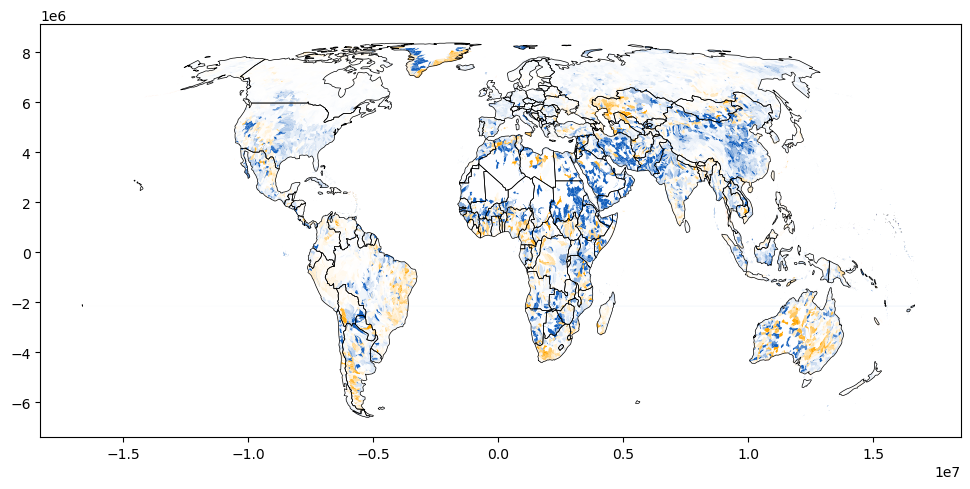

In [66]:


""" Global Map """

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

gdf = gpd.read_file("data\hydrobasin_6\hydrobasin_6.shp")
joined_gdf = gdf.merge(delta, on='PFAF_ID', how='right')


fig, ax = plt.subplots(figsize=(12, 5))

my_colormap = LinearSegmentedColormap.from_list("my_colormap", ['orange', 'white', '#1560bd'])
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# countries_filtered = countries[countries.geometry.apply(lambda x: x.bounds[0] > -125)]
countries_filtered = countries[countries.geometry.apply(lambda x: x.bounds[1] > -60)]


# joined_gdf.to_crs('+proj=eck4').plot(ax=ax, column='sign', cmap=my_colormap, vmin=-1, vmax=1)
joined_gdf.to_crs('+proj=eck4').plot(ax=ax, column='permanent_area', cmap=my_colormap, vmin=-100, vmax=100)
countries_filtered.to_crs('+proj=eck4').plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

plt.tight_layout()
fig.savefig('outputs_map/out_delta.png', dpi=300)


In [52]:
fig.savefig('out.png', dpi=300)